In [ ]:
### Uncomment and execute this entire codeblock if running from Colab!
# !git clone https://github.com/heqro/rd-dip
# !mv rd-dip/* .
# !git clone https://github.com/heqro/image-utils libs/image-utils
# !git clone https://github.com/heqro/brains-to-denoise datasets/
# !pip install piqa
# !pip install torch torchvision torchaudio
# !pip install scikit-image

We first import some libraries:

In [3]:
from piqa import PSNR, SSIM
import torch
import sys
sys.path.append("src")
sys.path.append("libs/image-utils/src")
from losses_and_regularizers import *
from denoise import Problem, ProblemImages, solve, initialize_experiment_report
from models import *
from noise import add_gaussian_noise, add_rician_noise
from spatial_transforms import crop_image
from my_io import  load_serialized_image, load_gray_image


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
psnr = PSNR()
ssim = SSIM(n_channels=1).to(dev)

Now, we choose our problem parameters: the index of the brain to denoise and the standard deviation of its noise.

In [4]:
# Index of the image to denoise (0, 1, ..., 10)
subject_idx = '8'
# Std of Rician noise (0.05, 0.10, ..., 0.40)
std = 0.15

We now load the noisy image, the ground-truth and its mask for accurately measuring PSNR and SSIM in the region of interest:

In [5]:
datapath='datasets/dataset'

gt_cpu = crop_image(load_serialized_image(f"{datapath}/im_{subject_idx}/gt.pt"))
mask_cpu = crop_image(load_gray_image(f"{datapath}/im_{subject_idx}/mask.png",as_mask=True))
noisy_gt_cpu = crop_image(load_serialized_image(
        f"{datapath}/im_{subject_idx}/Std{std}.pt", normalize=False))

We represent the images in the following:

(-0.5, 255.5, 255.5, -0.5)

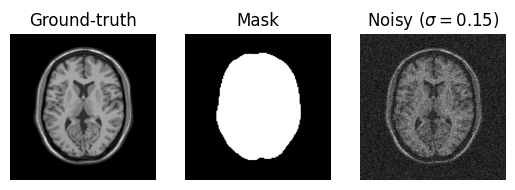

In [6]:
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(gt_cpu.squeeze(), cmap='gray')
plt.title('Ground-truth')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask_cpu.squeeze(), cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(noisy_gt_cpu.squeeze(), cmap='gray')
plt.title(r'Noisy $(\sigma=0.15)$')
plt.axis('off')

Now, we set up the parameters for the denoising experiment:

In [7]:
# model architecture
model = UNet().to(dev)
# useful data structure for storing images
images = ProblemImages(
    ground_truth = gt_cpu[None, ...],
    noisy_image = noisy_gt_cpu[None, ...],
    mask = mask_cpu[None, ...],
    rician_noise_std = float(std),
).to(dev)
# noisy, uniform, DIP seed
seed = 0.1 * torch.rand(1, 3, images.mask.shape[-2], images.mask.shape[-1]).to(
    images.noisy_image.device
)
composite_loss = load_experiment_config( # Bayesian formulation
    # In this case, 1*Rician_Norm + 0.15*DCT
    ['Rician_Norm:1.0:0.15'], ['Discrete_Cosine_Transform:0.15:3:1.0'])
p: Problem = {
    "images": images,
    "psnr": psnr, # piqa's psnr function
    "ssim": ssim, # piqa's ssim function
    "max_its": 300,
    "tag": 'Test_experiment',
    "optimizer": torch.optim.Adam(model.parameters(), lr=5e-4),
    "loss_config": composite_loss,
    "dip_config": {
        "noise_fn": add_rician_noise, # iterative Rician noise
        "std": 0.15, # iterative noise perturbation strength
        "model": model, # DIP model to use for denoising
        "seed": seed, # starting seed
        "simultaneous_perturbations": 1, # simultaneous perturbations applied to the seed
    },
    "image_name": f"im_{subject_idx}",
}
report = initialize_experiment_report(p)

We now denoise and represent the progress:

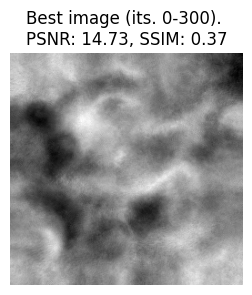

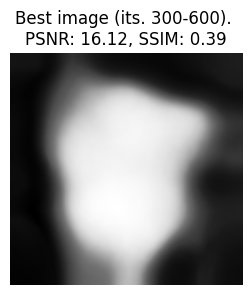

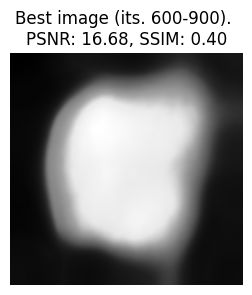

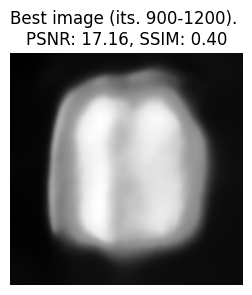

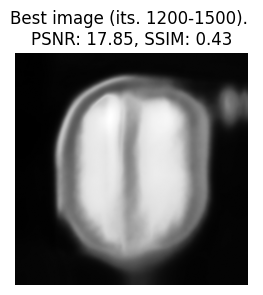

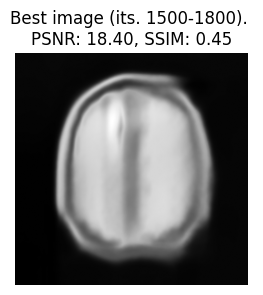

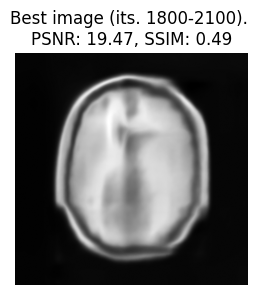

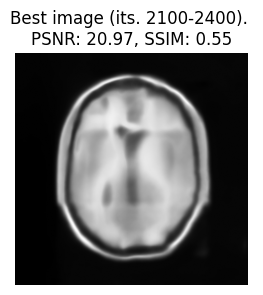

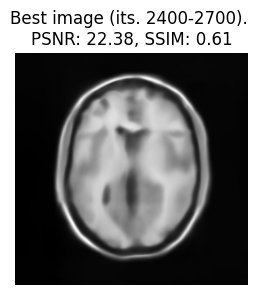

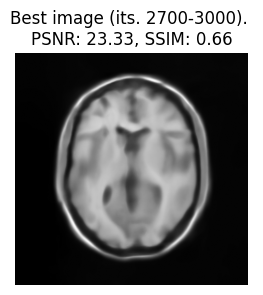

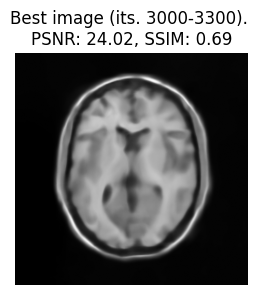

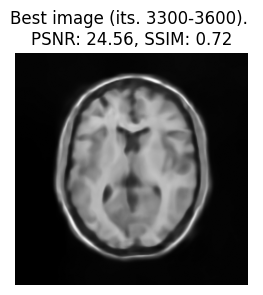

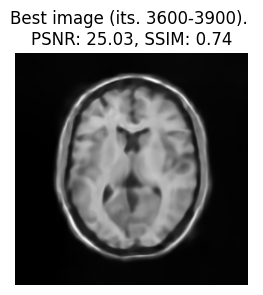

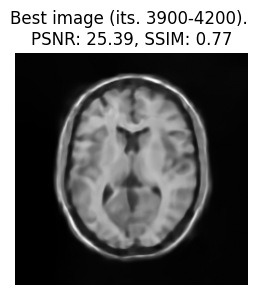

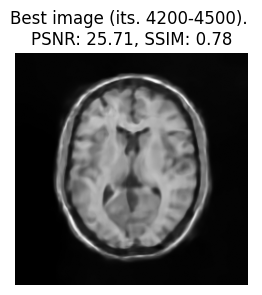

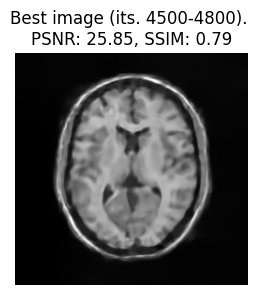

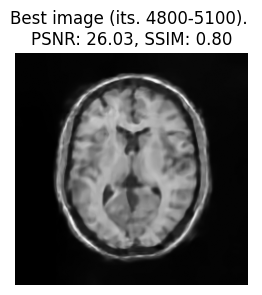

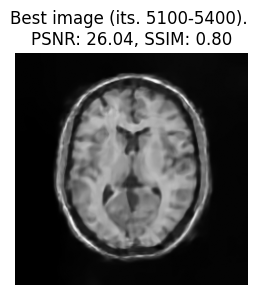

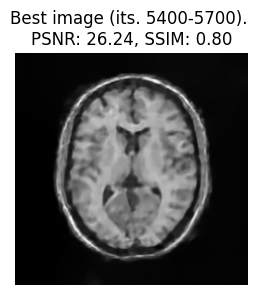

In [8]:
for it in range(1, 20):  # take 20 'best images'
    report, best_img = solve(p, report)
    best_psnr = max(report['psnr_mask_log'][-100::])
    best_ssim = max(report['ssim_mask_log'][-100::])
    plt.figure(figsize=(3, 4))
    plt.imshow(best_img.detach().cpu().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Best image (its. {300*(it-1)}-{300*it}). \nPSNR: {best_psnr:.2f}, SSIM: {best_ssim:.2f}')
    plt.show()